**HW7 Assignment**

**Name:** Praharshitha Singam

**G Number:** G01482612


The MLP’s penultimate layer learns a task-tuned embedding.

A tree ensemble (RF) on that embedding can exploit non-linear splits without relearning raw preprocessing, often boosting performance and giving feature importances over latent dimensions.

In [77]:
import os, glob, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


In [78]:
# ---------- uploaded CSV path ----------
candidates = [
    "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv",
    "./WA_Fn-UseC_-Telco-Customer-Churn.csv",
]
# also searching recursively in /content just in case to miss on anything
for p in glob.glob("/content/**/*.csv", recursive=True):
    if p.endswith("WA_Fn-UseC_-Telco-Customer-Churn.csv"):
        candidates.insert(0, p)

TELCO_CSV = next((p for p in candidates if os.path.exists(p)), None)
if TELCO_CSV is None:
    raise FileNotFoundError(
        "Couldn't find WA_Fn-UseC_-Telco-Customer-Churn.csv. "
        "If you just uploaded it, try: from google.colab import files; files.upload() "
        "and then rerun this cell."
    )
print("Using CSV:", TELCO_CSV)



Using CSV: /content/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [79]:
# ---------- Config ----------
SEED = 42
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 50
PATIENCE = 8
HIDDEN_DIMS = (128, 64)
DROPOUT = 0.15
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)



Device: cpu


Here I, Cleaned column names, maps target Churn → {Yes:1, No:0}.

Droped identifiers (customerID) to avoid leakage.

Fixeed TotalCharges (coerce non-numerics, median-impute).

One-hot encoded categoricals and kept numerics as is.

In [80]:
# ---------- Load & preprocess Telco ----------
def load_telco(path: str):
    df = pd.read_csv(path)
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]
    y = (df["Churn"].map({"Yes":1, "No":0})).astype(int)
    df = df.drop(columns=["Churn"])
    for col in ["customerID", "customer_Id", "CustomerID", "customerid"]:
        if col in df.columns:
            df = df.drop(columns=[col])
    if "TotalCharges" in df.columns:
        df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
        df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in df.columns if c not in num_cols]
    X = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    return X.values.astype(np.float32), y.values.astype(np.int64)

X, y = load_telco(TELCO_CSV)



Created a train / validation / test with the same churn ratio in each split (stratified). So that, Validation controls are stopped early & threshold selection can be made possible.


In [81]:
# ---------- Split: train/val/test ----------
def tvt_split(X, y, test_size=0.15, val_size=0.15, seed=SEED):
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=test_size+val_size, stratify=y, random_state=seed)
    rel_val = val_size / (test_size + val_size)
    X_va, X_te, y_va, y_te = train_test_split(X_tmp, y_tmp, test_size=(1-rel_val), stratify=y_tmp, random_state=seed)
    return X_tr, y_tr, X_va, y_va, X_te, y_te

X_tr, y_tr, X_va, y_va, X_te, y_te = tvt_split(X, y)



MLPs train better when inputs have comparable scales whileRF doesn’t need scaling, but i wanted to try and train RF on embeddings.

In [82]:
# ---------- Scale for MLP ----------
scaler = StandardScaler()
X_trs = scaler.fit_transform(X_tr)
X_vas = scaler.transform(X_va)
X_tes = scaler.transform(X_te)

def to_loader(X, y, batch=BATCH_SIZE, shuffle=False):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32),
                       torch.tensor(y.reshape(-1,1), dtype=torch.float32))
    return DataLoader(ds, batch_size=batch, shuffle=shuffle)

dl_train = to_loader(X_trs, y_tr, shuffle=True)
dl_val   = to_loader(X_vas, y_va, shuffle=False)



In [83]:
# ---------- MLP ----------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims=(128,64), dropout=0.15):
        super().__init__()
        dims = [in_dim] + list(hidden_dims)
        layers = []
        for i in range(len(dims)-1):
            layers += [nn.Linear(dims[i], dims[i+1]), nn.ReLU(), nn.Dropout(dropout)]
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(hidden_dims[-1], 1)
    def forward(self, x):
        z = self.backbone(x)
        return self.head(z)
    @torch.no_grad()
    def extract_penultimate(self, x):
        return self.backbone(x)

model = MLP(X_trs.shape[1], HIDDEN_DIMS, DROPOUT).to(DEVICE)



In [84]:
# Class imbalance
pos = (y_tr == 1).sum(); neg = (y_tr == 0).sum()
w = float(neg) / max(float(pos), 1.0)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([w], dtype=torch.float32, device=DEVICE))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ---------- Trainning with early stopping val AUC ----------
history = {"train_loss": [], "val_loss": [], "train_auc": [], "val_auc": []}
best_auc, best_state, patience_left = -np.inf, None, PATIENCE

def run_epoch(dl, train=True):
    model.train(mode=train)
    losses, probs_all, true_all = [], [], []
    for xb, yb in dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        if train:
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        losses.append(loss.detach().cpu().item())
        probs_all.append(torch.sigmoid(logits).detach().cpu().numpy().ravel())
        true_all.append(yb.detach().cpu().numpy().ravel())
    p = np.concatenate(probs_all) if probs_all else np.array([])
    t = np.concatenate(true_all)  if true_all  else np.array([])
    try:
        auc = roc_auc_score(t, p) if len(t) else float("nan")
    except ValueError:
        auc = float("nan")
    return float(np.mean(losses)), float(auc)

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_auc = run_epoch(dl_train, True)
    va_loss, va_auc = run_epoch(dl_val, False)
    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_auc"].append(tr_auc);   history["val_auc"].append(va_auc)
    if va_auc > best_auc + 1e-6:
        best_auc = va_auc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        patience_left = PATIENCE
    else:
        patience_left -= 1
        if patience_left == 0:
            break

if best_state is not None:
    model.load_state_dict(best_state)



In [85]:
# ---------- Evaluate MLP ----------
@torch.no_grad()
def predict_proba(m, Xn):
    m.eval()
    logits = m(torch.tensor(Xn, dtype=torch.float32, device=DEVICE))
    return torch.sigmoid(logits).cpu().numpy().ravel()

def metrics(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prc, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    try: auc = roc_auc_score(y_true, y_prob)
    except ValueError: auc = float("nan")
    return {"accuracy": acc, "precision": prc, "recall": rec, "f1": f1, "auc": auc}

mlp_test_prob = predict_proba(model, X_tes)
mlp_metrics = metrics(y_te, mlp_test_prob, 0.5)
print("\n=== Test metrics: MLP (direct) ===")
for k, v in mlp_metrics.items():
    print(f"{k:>9}: {v:.4f}")




=== Test metrics: MLP (direct) ===
 accuracy: 0.7559
precision: 0.5280
   recall: 0.7722
       f1: 0.6272
      auc: 0.8453


In [86]:
# ---------- Penultimate features ----------
@torch.no_grad()
def extract_feats(m, Xn):
    m.eval()
    return m.extract_penultimate(torch.tensor(Xn, dtype=torch.float32, device=DEVICE)).cpu().numpy()

Z_tr = extract_feats(model, X_trs)
Z_va = extract_feats(model, X_vas)
Z_te = extract_feats(model, X_tes)

# === Displaying extracted penultimate features ===

latent_cols = [f"z{i+1}" for i in range(Z_tr.shape[1])]
pd.set_option("display.max_columns", None)   # show all latent dims
N = 10

print("Train features:")
display(pd.DataFrame(Z_tr, columns=latent_cols).head(N))

print("Val features:")
display(pd.DataFrame(Z_va, columns=latent_cols).head(N))

print("Test features:")
display(pd.DataFrame(Z_te, columns=latent_cols).head(N))



Train features:


,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20,z21,z22,z23,z24,z25,z26,z27,z28,z29,z30,z31,z32,z33,z34,z35,z36,z37,z38,z39,z40,z41,z42,z43,z44,z45,z46,z47,z48,z49,z50,z51,z52,z53,z54,z55,z56,z57,z58,z59,z60,z61,z62,z63,z64
0,0.000000,0.954186,0.178221,0.204665,0.000000,0.000000,0.717398,0.000000,0.600792,0.164498,0.000000,1.138645,1.127917,0.898385,0.000000,0.158350,0.000000,0.805447,0.000000,0.000000,0.000000,0.000000,0.564786,0.000000,0.000000,0.832668,0.000000,0.000000,0.018001,0.227137,0.897279,0.198052,0.649664,0.676385,1.344746,0.548790,0.000000,0.163124,1.342677,0.032601,0.000000,1.108531,0.0,0.123245,0.634722,0.485070,0.000000,0.000000,0.000000,0.000000,0.593205,0.976722,0.000000,0.000000,0.000000,0.241197,0.072741,0.320816,0.508020,0.000000,0.935639,1.033224,0.000000,0.027507
1,0.000000,1.284371,0.444794,0.382275,0.000000,0.000000,1.097884,0.032966,0.652529,0.093580,0.000000,1.291076,1.360231,0.895752,0.000000,0.053175,0.000000,1.168841,0.000000,0.000000,0.000000,0.000000,0.796567,0.000000,0.000000,1.102432,0.000000,0.000000,0.000000,0.203226,1.302096,0.000000,1.039454,0.782150,1.595293,0.898637,0.000000,0.018116,1.709731,0.298677,0.000000,1.476728,0.0,0.089153,0.569975,1.206382,0.000000,0.000000,0.000000,0.000000,0.787665,1.197840,0.000000,0.000000,0.000000,0.005430,0.120522,0.474235,0.874304,0.000000,0.915470,1.188239,0.000000,0.277313
2,0.000000,0.977942,0.291641,0.534643,0.000000,0.000000,0.931227,0.079946,0.590446,0.000000,0.000000,1.181342,1.123296,0.754721,0.000000,0.083993,0.000000,0.846737,0.000000,0.000000,0.000000,0.000000,0.776755,0.000000,0.000000,1.324458,0.032570,0.000000,0.046565,0.000000,1.291590,0.000000,1.222575,0.901752,1.107849,0.493102,0.000000,0.000000,1.250700,0.000000,0.000000,1.053266,0.0,0.219592,0.651327,1.027748,0.000000,0.000000,0.114348,0.000000,0.424332,1.368069,0.000000,0.000000,0.000000,0.000000,0.000000,0.590810,0.280880,0.000000,1.107778,1.366290,0.000000,0.001234
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.257043,0.000000,1.130697,0.000000,0.834950,0.458674,0.184046,0.010874,0.049414,0.399407,0.632565,0.320782,0.000000,0.440514,0.000000,0.223141,0.473296,0.000000,0.139814,0.393896,0.000000,0.370984,0.186479,0.894042,0.855407,0.000000,0.417289,0.000000,0.000000,0.000000,0.000000,0.497419,0.763933,0.000000,0.916762,0.000000,0.000000,0.0,0.885367,0.000000,0.000000,0.000000,0.374998,0.078266,1.160471,0.000000,0.000000,0.000000,1.087748,0.849112,0.881392,0.883966,0.000000,0.000000,0.766690,0.008147,0.142335,0.212590,0.507497
4,0.000000,0.953953,0.653248,0.581893,0.000000,0.000000,0.874498,0.015682,0.594799,0.262630,0.188808,0.911484,0.453155,0.787978,0.000000,0.442388,0.000000,1.110276,0.000000,0.010331,0.051927,0.013706,0.416046,0.363513,0.000000,0.833243,0.000000,0.023009,0.056536,0.013154,0.970646,0.202340,0.797359,0.443617,1.138988,0.405742,0.000000,0.548906,1.263507,0.263601,0.087904,0.668183,0.0,0.309401,0.233581,0.487450,0.000000,0.169990,0.000000,0.111569,0.656972,0.352121,0.000000,0.000000,0.352897,0.156564,0.104632,0.240367,0.530531,0.254022,1.214381,1.067445,0.109382,0.262657
5,1.263641,0.000000,0.000000,0.000000,0.534275,1.796309,0.000000,1.706227,0.000000,2.146269,1.708863,0.000000,0.000000,0.000000,1.462311,1.029137,1.145304,0.000000,1.183848,1.506074,0.783824,1.329089,0.000000,0.666197,1.255908,0.000000,1.370316,1.174037,1.705957,1.226704,0.000000,1.111617,0.000000,0.000000,0.000000,0.000000,1.030308,1.900761,0.000000,1.421379,1.889622,0.000000,0.0,2.198802,0.000000,0.000000,0.981077,1.184722,0.470502,1.522723,0.000000,0.000000,0.562226,1.673972,1.822271,1.688506,1.128418,0.000000,0.000000,1.633520,0.000000,0.000000,0.844386,1.716216
6,0.698194,0.416909,0.000000,0.000000,0.045425,0.316027,0.165188,0.516129,0.000000,0.932874,0.582440,0.314718,0.000000,0.000000,0.827037,0.118664,0.000000,0.000000,0.243511,0.445855,0.071086,0.698876,0.182250,0.089438,0.454073,0.349152,0.677106,0.378916,0.291152,0.612762,0.000000,0.515803,0.000000,0.416882,0.5885

Val features:


,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20,z21,z22,z23,z24,z25,z26,z27,z28,z29,z30,z31,z32,z33,z34,z35,z36,z37,z38,z39,z40,z41,z42,z43,z44,z45,z46,z47,z48,z49,z50,z51,z52,z53,z54,z55,z56,z57,z58,z59,z60,z61,z62,z63,z64
0,1.393501,0.105784,0.000000,0.000000,0.230484,1.643478,0.000000,1.277881,0.000000,1.813882,1.533308,0.000000,0.000000,0.000000,1.363061,0.553369,1.014332,0.000000,1.188511,1.459059,0.863764,0.890414,0.000000,0.609398,1.167389,0.352099,1.245654,1.160249,1.596829,0.880886,0.000000,1.177903,0.000000,0.000000,0.016089,0.113869,0.868369,1.821703,0.132863,1.126867,1.712539,0.000000,0.0,2.249299,0.000000,0.007376,0.894186,1.056281,0.348965,1.123007,0.069308,0.000000,0.647142,1.292688,1.466190,1.341866,0.666929,0.000000,0.000000,1.288018,0.117291,0.263756,1.080498,1.549970
1,0.000000,0.845789,0.251243,0.344751,0.000000,0.000000,0.888578,0.000000,0.508154,0.126868,0.000000,0.925882,1.019395,0.703712,0.000000,0.165454,0.000000,0.838672,0.000000,0.000000,0.000000,0.000000,0.774215,0.127649,0.000000,0.823444,0.000000,0.000000,0.000000,0.000000,1.210710,0.000000,0.993968,0.757047,1.022614,0.707249,0.000000,0.269174,1.405431,0.000000,0.000000,0.876497,0.0,0.122113,0.736161,0.789455,0.000000,0.000000,0.000000,0.000000,0.468337,0.990805,0.000000,0.000000,0.000000,0.000000,0.182897,0.200083,0.902900,0.053850,0.980342,0.931686,0.000000,0.289183
2,0.000000,0.106295,0.000000,0.000000,0.000000,0.535710,0.000000,0.986017,0.000000,1.288408,0.758989,0.148679,0.000000,0.103531,0.282042,0.382520,0.737195,0.033762,0.167738,0.589871,0.000000,0.472701,0.000000,0.159151,0.442292,0.000000,0.562149,0.364460,0.830549,0.497346,0.206623,0.590490,0.000000,0.008454,0.007051,0.000000,0.374998,1.028819,0.292099,0.962356,0.251612,0.000000,0.0,0.754229,0.000000,0.000000,0.177244,0.016872,0.283030,1.005246,0.012882,0.000000,0.191357,0.824890,0.947208,0.405581,1.019841,0.000000,0.225686,0.901468,0.461069,0.000000,0.162925,0.603000
3,0.220772,0.000000,0.000000,0.000000,0.000000,0.563673,0.000000,1.275898,0.000000,1.119484,0.982600,0.000000,0.000000,0.000000,0.459505,0.400572,0.880428,0.179790,0.468877,0.696563,0.322289,0.901423,0.000000,0.395891,0.644399,0.000000,0.597180,0.707713,0.961831,0.916517,0.000000,0.299014,0.000000,0.000000,0.000000,0.000000,0.495323,0.962129,0.000000,1.014823,0.393601,0.000000,0.0,1.173587,0.000000,0.000000,0.411037,0.538507,0.050130,1.233292,0.000000,0.000000,0.000000,0.797149,0.929228,1.008088,0.833620,0.000000,0.000000,1.004330,0.005413,0.000000,0.510321,0.936261
4,0.000000,0.985186,0.269527,0.311998,0.000000,0.000000,0.978244,0.000000,0.635792,0.000000,0.000000,1.201565,1.314980,0.772480,0.000000,0.123541,0.000000,0.864294,0.000000,0.000000,0.000000,0.000000,0.757484,0.000000,0.000000,1.028831,0.000000,0.000000,0.000000,0.044224,1.261066,0.000000,0.973394,0.940550,1.295794,0.852897,0.000000,0.107283,1.457815,0.008626,0.000000,1.235048,0.0,0.081367,0.856190,0.899705,0.000000,0.000000,0.000000,0.000000,0.512006,1.167258,0.000000,0.000000,0.000000,0.007439,0.000000,0.393240,0.685523,0.000000,1.020974,1.096642,0.000000,0.196142
5,0.000000,1.214568,0.752348,0.617823,0.000000,0.000000,1.365505,0.000000,1.049627,0.000000,0.000000,1.544075,1.202994,0.972107,0.000000,0.087704,0.000000,1.246292,0.000000,0.000000,0.000000,0.000000,0.894827,0.000000,0.000000,1.531371,0.000000,0.000000,0.000000,0.000000,1.475761,0.000000,1.217239,1.022359,1.382615,1.131674,0.000000,0.038909,1.589620,0.029595,0.000000,1.373469,0.0,0.090097,0.892214,1.166063,0.000000,0.000000,0.000000,0.000000,0.607293,1.414808,0.000000,0.000000,0.000000,0.000000,0.000000,0.678455,0.622773,0.000000,1.400715,1.778356,0.000000,0.125821
6,0.000000,0.895985,0.433112,0.545175,0.000000,0.000000,0.734649,0.015672,0.486985,0.133050,0.002339,0.689238,0.336840,0.755677,0.000000,0.378027,0.012509,0.711761,0.000000,0.000000,0.049393,0.000000,0.554120,0.177685,0.000000,0.814578,0.000000,0.000000,0.000000,0.146191,0.717903,0.135089,0.676666,0.416353,1.0373

Test features:


,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20,z21,z22,z23,z24,z25,z26,z27,z28,z29,z30,z31,z32,z33,z34,z35,z36,z37,z38,z39,z40,z41,z42,z43,z44,z45,z46,z47,z48,z49,z50,z51,z52,z53,z54,z55,z56,z57,z58,z59,z60,z61,z62,z63,z64
0,0.000000,0.399608,0.000000,0.000000,0.000000,0.000000,0.603723,0.276811,0.182429,0.099117,0.186233,0.861201,0.953213,0.343564,0.000000,0.346017,0.000000,0.717074,0.000000,0.000000,0.000000,0.000000,0.419085,0.000000,0.139730,0.575480,0.077060,0.198970,0.000000,0.373593,0.853522,0.000000,0.420179,0.788183,0.795899,0.480952,0.000000,0.153968,0.838554,0.549406,0.016792,1.035511,0.0,0.317402,0.582756,0.567549,0.000000,0.000000,0.000000,0.094885,0.177712,0.609024,0.000000,0.194160,0.035497,0.248258,0.127033,0.257354,0.468487,0.201701,0.339015,0.399608,0.000000,0.375958
1,0.204703,0.030238,0.000000,0.000000,0.000000,0.541969,0.150239,0.219411,0.016326,0.948780,0.806210,0.046548,0.341154,0.171161,0.264052,0.287909,0.234622,0.125636,0.214149,0.370242,0.440390,0.168742,0.000000,0.334766,0.634868,0.068622,0.344608,0.444891,0.778974,0.647160,0.229954,1.081434,0.000000,0.223205,0.104533,0.000000,0.491777,1.167107,0.153463,0.708888,0.619846,0.071512,0.0,1.074106,0.153003,0.000000,0.472319,0.669424,0.060452,0.701274,0.000000,0.007854,0.000000,0.626533,0.890393,0.873354,0.328761,0.000000,0.289333,0.755326,0.074699,0.218642,0.686168,0.230765
2,0.000000,0.196072,0.000000,0.000000,0.057996,0.738503,0.000000,1.264702,0.000000,1.154180,0.963328,0.000000,0.000000,0.117623,0.400785,0.702442,0.530080,0.000000,0.526617,0.737068,0.500601,0.573089,0.000000,0.756735,0.576942,0.000000,0.717257,0.414124,1.010936,0.909921,0.000000,0.479138,0.000000,0.000000,0.000000,0.029343,0.449924,1.088847,0.000000,1.098343,0.678806,0.000000,0.0,1.082340,0.000000,0.000000,0.501620,0.631965,0.056962,1.055673,0.000000,0.000000,0.000000,0.827448,0.748134,0.958975,0.795330,0.000000,0.000000,1.047812,0.113807,0.000000,0.562267,0.938702
3,0.000000,0.125571,0.000000,0.000000,0.107066,0.024057,0.153938,0.612914,0.070157,0.959809,0.524572,0.337598,0.211293,0.258579,0.341859,0.767165,0.212297,0.413169,0.000000,0.335279,0.141100,0.200038,0.000000,0.070646,0.000000,0.000000,0.470224,0.000000,0.777470,0.487458,0.000000,0.371026,0.000000,0.091014,0.258948,0.000000,0.235444,0.978926,0.520642,0.648799,0.158887,0.000000,0.0,0.284586,0.071643,0.000000,0.452275,0.173277,0.000000,0.617489,0.000000,0.043361,0.013167,0.327730,0.663309,0.228667,0.616225,0.000000,0.054735,0.516998,0.391357,0.138711,0.220550,0.112167
4,0.264877,0.000000,0.000000,0.000000,0.000000,0.783891,0.000000,1.729234,0.000000,1.292540,1.458679,0.000000,0.000000,0.000000,0.856533,1.278746,1.202654,0.000000,0.944197,1.205696,0.595569,0.797025,0.000000,0.658821,0.965744,0.000000,0.693207,1.089273,1.536746,1.270268,0.000000,0.187778,0.000000,0.104349,0.000000,0.000000,0.355357,1.556599,0.000000,1.651024,0.616879,0.000000,0.0,1.384080,0.000000,0.000000,0.598501,1.170736,0.000000,1.221435,0.000000,0.000000,0.000000,0.893992,1.216236,1.112661,0.786157,0.000000,0.142153,1.274633,0.000000,0.000000,1.351652,1.331667
5,0.841470,0.523261,0.000000,0.000000,0.000000,0.480707,0.296855,0.413313,0.000000,1.026348,0.575150,0.417311,0.144300,0.000000,0.771521,0.000000,0.045907,0.000000,0.489604,0.357147,0.000000,0.546221,0.236845,0.037197,0.514599,0.578905,0.658599,0.225563,0.417169,0.387920,0.128701,0.593328,0.026830,0.419647,0.571143,0.142533,0.198354,0.961425,0.608377,0.291728,0.932031,0.389001,0.0,1.005914,0.460902,0.156245,0.190207,0.104312,0.000743,0.124969,0.354670,0.000000,0.101222,0.707710,0.479536,0.547115,0.148643,0.000000,0.000000,0.614551,0.691361,0.471543,0.284907,0.663429
6,1.276793,0.000000,0.000000,0.000000,0.348727,1.797105,0.000000,1.865656,0.000000,1.727464,1.835437,0.000000,0.000000,0.000000,1.493987,0.704634,1.311871,0.000000,1.387105,1.599682,1.094289,1.085943,0.000000,0.667898,1.410993,0.000000,1.397610,1.348766,1.602106,1.215689,0.000000,0.841470,0.000000,0.000000,0.0000

The RF exploited the embedding’s structure with non-linear splits. Training on train+val gives it more data (where I tuned thresholds earlier on val; and use val for RF training to avoid using the same val for threshold selection to prevent leakage).

In [87]:
# ---------- RF on penultimate features ----------
Z_trva = np.vstack([Z_tr, Z_va])
y_trva = np.concatenate([y_tr, y_va])
rf = RandomForestClassifier(n_estimators=400, max_depth=None, random_state=SEED, n_jobs=-1, class_weight="balanced_subsample")
rf.fit(Z_trva, y_trva)
rf_test_prob = rf.predict_proba(Z_te)[:, 1]
rf_metrics = metrics(y_te, rf_test_prob, 0.5)

print("\n=== Test metrics: Random Forest on MLP penultimate features ===")
for k, v in rf_metrics.items():
    print(f"{k:>9}: {v:.4f}")

print("\n=== Side-by-side (Test) ===")
for k in ["accuracy","precision","recall","f1","auc"]:
    print(f"{k:>9}:  MLP={mlp_metrics[k]:.4f}   RF_on_feats={rf_metrics[k]:.4f}")




=== Test metrics: Random Forest on MLP penultimate features ===
 accuracy: 0.7862
precision: 0.6536
   recall: 0.4164
       f1: 0.5087
      auc: 0.8264

=== Side-by-side (Test) ===
 accuracy:  MLP=0.7559   RF_on_feats=0.7862
precision:  MLP=0.5280   RF_on_feats=0.6536
   recall:  MLP=0.7722   RF_on_feats=0.4164
       f1:  MLP=0.6272   RF_on_feats=0.5087
      auc:  MLP=0.8453   RF_on_feats=0.8264


MLP @thr=0.854 | acc=0.768 prec=0.731 rec=0.203 f1=0.318 auc=0.845
RF-on-feats @thr=0.177 | acc=0.716 prec=0.481 rec=0.854 f1=0.615 auc=0.826


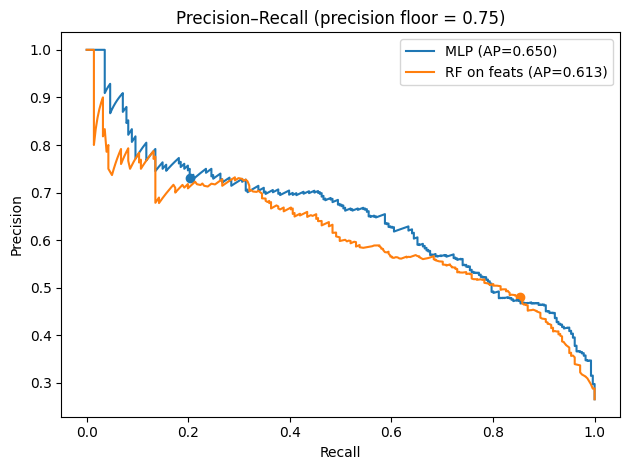

In [88]:
# ----- Minimal recall-vs-precision tuning + single PR plot ------
# 1) to point the threshold that maximizes RECALL subject to a PRECISION floor
def thr_max_recall_with_precision_floor(y_true, y_prob, p_floor=0.70):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)   # len(thr) = len(prec)-1
    best_t, best_r = None, -1.0
    for i in range(len(thr)):
        if prec[i] >= p_floor and rec[i] > best_r:
            best_r, best_t = rec[i], thr[i]
    # fallback: max F1 if no point meets the floor
    if best_t is None:
        grid = np.linspace(0, 1, 501)
        f1s = [f1_score(y_true, (y_prob >= t).astype(int), zero_division=0) for t in grid]
        best_t = float(grid[int(np.argmax(f1s))])
    return float(best_t)

# Validation probabilities
mlp_val_prob = predict_proba(model, X_vas)
rf_val_prob  = rf.predict_proba(Z_va)[:, 1]

P_FLOOR = 0.75  # <-- setting my own minimum acceptable precision and observe the changes
t_mlp = thr_max_recall_with_precision_floor(y_va, mlp_val_prob, P_FLOOR)
t_rf  = thr_max_recall_with_precision_floor(y_va, rf_val_prob,  P_FLOOR)

# 2) Compact test report
def report(y_true, y_prob, t, name):
    yhat = (y_prob >= t).astype(int)
    print(f"{name} @thr={t:.3f} | acc={ (yhat==y_true).mean():.3f} "
          f"prec={precision_score(y_true,yhat,zero_division=0):.3f} "
          f"rec={recall_score(y_true,yhat,zero_division=0):.3f} "
          f"f1={f1_score(y_true,yhat,zero_division=0):.3f} "
          f"auc={roc_auc_score(y_true,y_prob):.3f}")

report(y_te, mlp_test_prob, t_mlp, "MLP")
report(y_te, rf_test_prob,  t_rf,  "RF-on-feats")

# 3) Single PR curve figure with chosen points marked
p1, r1, _ = precision_recall_curve(y_te, mlp_test_prob)
p2, r2, _ = precision_recall_curve(y_te, rf_test_prob)
plt.figure()
plt.plot(r1, p1, label=f"MLP (AP={average_precision_score(y_te, mlp_test_prob):.3f})")
plt.plot(r2, p2, label=f"RF on feats (AP={average_precision_score(y_te, rf_test_prob):.3f})")

pm = precision_score(y_te, (mlp_test_prob>=t_mlp).astype(int), zero_division=0)
rm = recall_score(y_te, (mlp_test_prob>=t_mlp).astype(int), zero_division=0)
pr = precision_score(y_te, (rf_test_prob>=t_rf).astype(int),  zero_division=0)
rr = recall_score(y_te, (rf_test_prob>=t_rf).astype(int),     zero_division=0)
plt.scatter([rm],[pm]); plt.scatter([rr],[pr])

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall (precision floor = {P_FLOOR:.2f})")
plt.legend(); plt.tight_layout(); plt.show()


From above results,

If RF AUC > MLP AUC, it implies that the embedding was helpful and the tree model capitalized on it. And,

If MLP AUC ≥ RF AUC, then MLP head is already strong or may need more tuning

And from the plot,
The dot from the above plot marks the single threshold I decided to use, picked on the validation set using your rule (e.g., “maximize recall subject to precision ≥ P_FLOOR”).

On the test set, the dot’s coordinates are:

x = recall at that threshold

y = precision at that threshold

So, to explain this, say a dot at (recall=0.72, precision=0.62) implies that with the chosen threshold, the model can catch 72% of churners, and 62% of predicted-churners are truly churners.

In [89]:
# ---------- Confusion matrices ----------
y_mlp = (mlp_test_prob >= 0.5).astype(int)
y_rff = (rf_test_prob >= 0.5).astype(int)
print("\nConfusion Matrix — MLP:\n", confusion_matrix(y_te, y_mlp))
print("\nConfusion Matrix — RF on feats:\n", confusion_matrix(y_te, y_rff))




Confusion Matrix — MLP:
 [[582 194]
 [ 64 217]]

Confusion Matrix — RF on feats:
 [[714  62]
 [164 117]]


Here, Confusion matrices quantify FP/FN trade-offs at P_Floor Value.

And, ROC curves visualize ranking performance, while training curves verify no overfit (val curves track train curves).

Note: One thing I observed is that changing P_FLOOR didn't change the PR curve or AP itself (those depend only on model scores). It changes the dot (operating point).

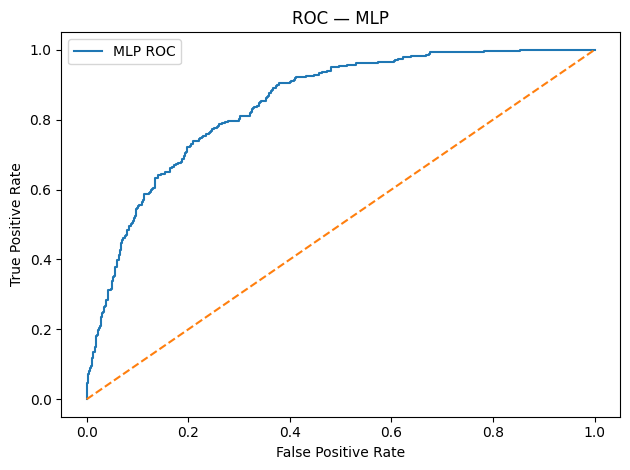

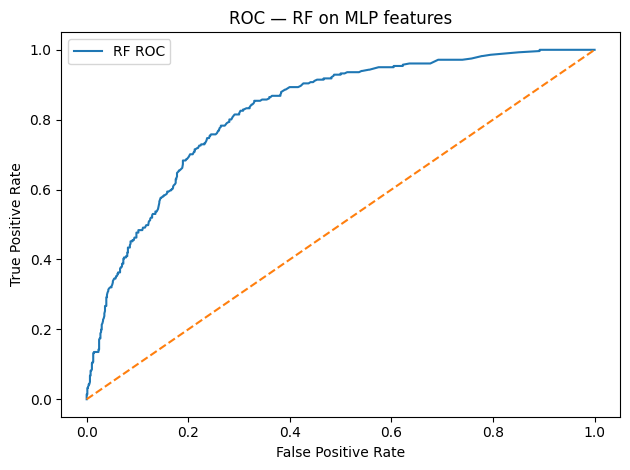

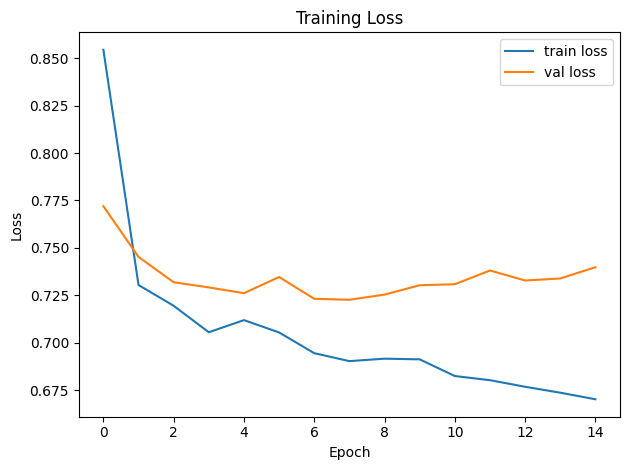

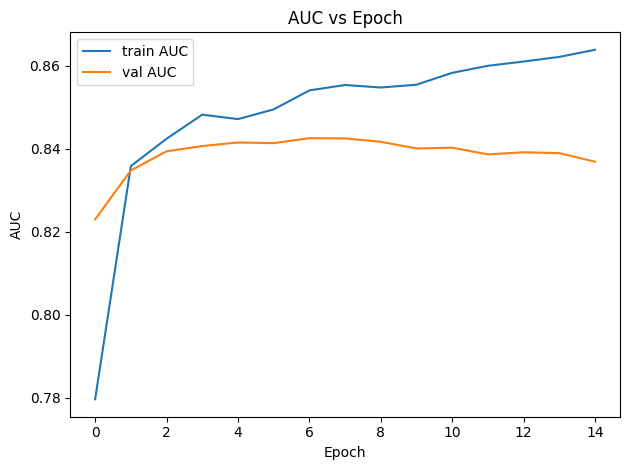

In [90]:
# ---------- Plots  ----------
fpr1, tpr1, _ = roc_curve(y_te, mlp_test_prob)
plt.figure(); plt.plot(fpr1, tpr1, label="MLP ROC"); plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC — MLP"); plt.legend(); plt.tight_layout(); plt.show()

fpr2, tpr2, _ = roc_curve(y_te, rf_test_prob)
plt.figure(); plt.plot(fpr2, tpr2, label="RF ROC"); plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC — RF on MLP features"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(history["train_loss"], label="train loss"); plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(history["train_auc"], label="train AUC"); plt.plot(history["val_auc"], label="val AUC")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.title("AUC vs Epoch"); plt.legend(); plt.tight_layout(); plt.show()


Interpretation.

If RF > MLP on AUC, the MLP embedding helped and trees exploited it, this supports the “deep feature extraction + tree ensemble” strategy for tabular churn.

If MLP ≥ RF, to be considered would be,
More layers/neurons let the network learn richer patterns. Add dropout if it starts overfitting.
A larger last hidden layer creates a richer embedding, which can help both the MLP head and the RF.If training is cut early, the model may be underfit.
In churn, having “keep precision ≥ X% and maximize recall.” would be betterso that the threshold can be meet. ANd based on that it cna also imply that fine tuning might be needed.